# **Brief 8 - La roue des émotions**

## **I) On travail sur le fichier Emotion_final.csv**

In [1]:
# import
import pandas as pds
import string
import numpy as np

#for machine Learning - classification 
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV

# for visuaiization
import seaborn as sns
import matplotlib.pyplot as plt

#for NLP
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

import nltk # A supprimer si OK

## **1) Récupération des données**  
Ce fichier contient 2 colonnes: **Text** contenant les textes des messages et **Emotion** contenant l'émotion associé au message.  
Liste des émotions:'sadness' 'anger' 'love' 'surprise' 'fear' 'happy'  
Nombre de messages: 21459

In [2]:
data_emo= pds.read_csv('./visu/data/Emotion_final.csv')
#, engine= "python", encoding='utf-8', error_bad_lines=False) # nécessaire sur google

print(data_emo.info())
print("Liste des emotions:\n",data_emo.Emotion.unique())
print("Les 10 premiers enregistrements:\n",data_emo.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21459 entries, 0 to 21458
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     21459 non-null  object
 1   Emotion  21459 non-null  object
dtypes: object(2)
memory usage: 335.4+ KB
None
Liste des emotions:
 ['sadness' 'anger' 'love' 'surprise' 'fear' 'happy']
Les 10 premiers enregistrements:
                                                 Text   Emotion
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger
5  ive been feeling a little burdened lately wasn...   sadness
6  ive been taking or milligrams or times recomme...  surprise
7  i feel as confused about life as a teenager or...      fear
8  i have been with pe

## **2) Pré-traitement des données**

### **a) Tokenisation**  
Bien que cette opération soit incluse dans la vectorisation et est donc inutile à ce stade, elle est réalisée à titre d'exercice. Elle pourrait aussi servir pour faciliter un pré traitement des donnéees (pour repérer plus facilement les émoticones par exemple et les ré-associé comme 1 seul mots. les émoticones suivant :), :-), =], :D serait remplacé par le mot sourire ou laissé tel quel).  
  
On crée aussi une nouvelle colonne que l'on rajoute à la data frame de départ contenant le texte "tokénisé".

In [3]:
# Tokenisation

# Création d'une colonne tokenisée
corpus=[]
for el in data_emo.Text:
    token= word_tokenize(el)
    corpus.append(token)
data_emo['token_brut'] = pds.Series(corpus)
print(data_emo.token_brut.head(10))

0                         [i, didnt, feel, humiliated]
1    [i, can, go, from, feeling, so, hopeless, to, ...
2    [im, grabbing, a, minute, to, post, i, feel, g...
3    [i, am, ever, feeling, nostalgic, about, the, ...
4                            [i, am, feeling, grouchy]
5    [ive, been, feeling, a, little, burdened, late...
6    [ive, been, taking, or, milligrams, or, times,...
7    [i, feel, as, confused, about, life, as, a, te...
8    [i, have, been, with, petronas, for, years, i,...
9                             [i, feel, romantic, too]
Name: token_brut, dtype: object


### **b) Tokénisation en ayant retiré les "stopword"**  
Ici on créera 2 nouvelles colonnes à la data frame du départ: Une contenant le résultat de la tokénisation, une autre contiendra une phrase reconstituer sans les stopword et qui pourra nous servir dans les tests plus loin. 

In [4]:
# Création d'une colonne tokenisée sans stopwords avec ponctuation (important pour les émoticones)
# exclude = set(string.punctuation)
stopwords=nltk.corpus.stopwords.words('english')
#stopwords.extend(exclude)

corpus=[]
#print(stopwords)
for el in data_emo.token_brut:
    token=[]
    #print("type:",type(el),"el|",el,"|")
    for wd in el:
        #print(wd)
        if wd not in stopwords:
            token.append(wd)
    corpus.append(token)
data_emo['token_sans_stopwd'] = pds.Series(corpus)

data_emo.token_sans_stopwd.head(10)

0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
3    [ever, feeling, nostalgic, fireplace, know, st...
4                                   [feeling, grouchy]
5    [ive, feeling, little, burdened, lately, wasnt...
6    [ive, taking, milligrams, times, recommended, ...
7    [feel, confused, life, teenager, jaded, year, ...
8    [petronas, years, feel, petronas, performed, w...
9                                     [feel, romantic]
Name: token_sans_stopwd, dtype: object

In [5]:
corpus= data_emo['token_sans_stopwd']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el)
    corpus2.append(ligne)

data_emo['phrase_sans_stopwd'] = pds.Series(corpus2)

print(data_emo.phrase_sans_stopwd.head(10))

0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
5        ive feeling little burdened lately wasnt sure
6    ive taking milligrams times recommended amount...
7       feel confused life teenager jaded year old man
8    petronas years feel petronas performed well ma...
9                                        feel romantic
Name: phrase_sans_stopwd, dtype: object


### **c) Lemantisation et normalisation**  
On créera deux autres colones dans la data frame, une colonne contenant une liste "lémantisé" et la phrase corresponsdantes.

In [6]:
# Lemantisation et normalisation
lemma = WordNetLemmatizer()

corpus=[]
#print(stopwords)
for el in data_emo.token_sans_stopwd:
    token=[]
    #print("type:",type(el),"el|",el,"|")
    token=[lemma.lemmatize(word.lower()) for word in el]
    corpus.append(token)


data_emo['lemn_normal'] = pds.Series(corpus)

data_emo.lemn_normal.head(10)

0                            [didnt, feel, humiliated]
1    [go, feeling, hopeless, damned, hopeful, aroun...
2    [im, grabbing, minute, post, feel, greedy, wrong]
3    [ever, feeling, nostalgic, fireplace, know, st...
4                                   [feeling, grouchy]
5    [ive, feeling, little, burdened, lately, wasnt...
6    [ive, taking, milligram, time, recommended, am...
7    [feel, confused, life, teenager, jaded, year, ...
8    [petronas, year, feel, petronas, performed, we...
9                                     [feel, romantic]
Name: lemn_normal, dtype: object

In [7]:
corpus= data_emo['lemn_normal']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el)
    corpus2.append(ligne)

data_emo['phrase_lemn_normal'] = pds.Series(corpus2)

print(data_emo.phrase_lemn_normal.head(10))

0                                didnt feel humiliated
1    go feeling hopeless damned hopeful around some...
2            im grabbing minute post feel greedy wrong
3    ever feeling nostalgic fireplace know still pr...
4                                      feeling grouchy
5        ive feeling little burdened lately wasnt sure
6    ive taking milligram time recommended amount i...
7       feel confused life teenager jaded year old man
8    petronas year feel petronas performed well mad...
9                                        feel romantic
Name: phrase_lemn_normal, dtype: object


### **d) Les N-grams:**  
Les n-grams sont des suites de mots présents dans le texte. Il pourrait être trés utile pour reconstituer les émoticones ainsi que les mots composés.  
Il ne seront pas traité ici (pour ce fichier et faute de temps) mais utilisé en passant l'option n-grams dans les fonctions de vectorisation de sklearn.

### **e) Quelques statistiques sur le contenu des messages**  
On pourrait utiliser le dictionnaire pour voir les mots mal orthographié (en faisant un tri par ordre alphabétique), et ainsi "corriger les messages". **Ceci pourrait s'avérer utile pour le 2ème fichiers de données** pour améliorer les résultats trés décevant.

In [8]:
dictionnairetb={}
dictionnairetb_plus_de_10= {}
for liste in data_emo.token_brut:
    for mot in liste:
        if dictionnairetb.get(mot):
            dictionnairetb[mot]+= 1
        else:
            dictionnairetb[mot]= 1

for cle, valeur in dictionnairetb.items():
    if valeur >= 10:
        dictionnairetb_plus_de_10[cle]=valeur
print("Vocabulaire dans la colonne 'Token_brut'")
print("Le nombre de mots est de : {}\nLe nombre de mots revenant 10 fois au moins est de {}".format(
    len(dictionnairetb),len(dictionnairetb_plus_de_10)))

dictionnairest={}
dictionnairest_plus_de_10= {}
for liste in data_emo.token_sans_stopwd:
    for mot in liste:
        if dictionnairest.get(mot):
            dictionnairest[mot]+= 1
        else:
            dictionnairest[mot]= 1

for cle, valeur in dictionnairest.items():
    if valeur >= 10:
        dictionnairest_plus_de_10[cle]=valeur
print("Vocabulaire dans la colonne 'Token_sans_stopwd'")
print("Le nombre de mots est de : {}\nLe nombre de mots revenant 10 fois au moins est de {}".format(
    len(dictionnairest),len(dictionnairest_plus_de_10)))


dictionnairel={}
dictionnairel_plus_de_10= {}
for liste in data_emo.lemn_normal:
    for mot in liste:
        if dictionnairel.get(mot):
            dictionnairel[mot]+= 1
        else:
            dictionnairel[mot]= 1

for cle, valeur in dictionnairel.items():
    if valeur >= 10:
        dictionnairel_plus_de_10[cle]=valeur
print("Vocabulaire dans la colonne 'lémantisé'")
print("Le nombre de mots est de : {}\nLe nombre de mots revenant 10 fois au moins est de {}".format(
    len(dictionnairel),len(dictionnairel_plus_de_10)))

print("Voici la liste des mots trié par occurrences:\n",
      sorted(dictionnairetb.items(), key=lambda t: t[1],reverse=True))

Vocabulaire dans la colonne 'Token_brut'
Le nombre de mots est de : 20015
Le nombre de mots revenant 10 fois au moins est de 2654
Vocabulaire dans la colonne 'Token_sans_stopwd'
Le nombre de mots est de : 19866
Le nombre de mots revenant 10 fois au moins est de 2514
Vocabulaire dans la colonne 'lémantisé'
Le nombre de mots est de : 17269
Le nombre de mots revenant 10 fois au moins est de 2464
Voici la liste des mots trié par occurrences:
 [('i', 32247), ('feel', 13973), ('and', 12699), ('to', 11818), ('the', 11672), ('a', 8295), ('of', 6816), ('that', 6533), ('feeling', 6458), ('my', 5413), ('in', 4650), ('it', 4050), ('like', 3659), ('was', 3277), ('so', 3206), ('for', 3177), ('im', 3055), ('me', 2944), ('but', 2910), ('have', 2885), ('is', 2808), ('with', 2727), ('this', 2673), ('am', 2608), ('not', 2513), ('about', 2384), ('be', 2296), ('as', 2110), ('on', 2072), ('you', 1941), ('at', 1907), ('just', 1837), ('when', 1795), ('or', 1608), ('all', 1499), ('more', 1471), ('because', 146

Représentation des mots en fonction de leurs occurrence.

In [9]:
dic={}
for liste in data_emo.token_brut:
    for mot in liste:
        if dic.get(mot):
            dic[mot]+= 1
        else:
            dic[mot]= 1
liste_mot= sorted(dictionnairetb.items(), key=lambda t: t[1],reverse=True)
print(liste_mot)

[('i', 32247), ('feel', 13973), ('and', 12699), ('to', 11818), ('the', 11672), ('a', 8295), ('of', 6816), ('that', 6533), ('feeling', 6458), ('my', 5413), ('in', 4650), ('it', 4050), ('like', 3659), ('was', 3277), ('so', 3206), ('for', 3177), ('im', 3055), ('me', 2944), ('but', 2910), ('have', 2885), ('is', 2808), ('with', 2727), ('this', 2673), ('am', 2608), ('not', 2513), ('about', 2384), ('be', 2296), ('as', 2110), ('on', 2072), ('you', 1941), ('at', 1907), ('just', 1837), ('when', 1795), ('or', 1608), ('all', 1499), ('more', 1471), ('because', 1464), ('do', 1343), (',', 1339), ('can', 1336), ('up', 1226), ('really', 1201), ('by', 1191), ('t', 1175), ('are', 1168), ('very', 1142), ('been', 1127), ('he', 1098), ('know', 1091), ('had', 1087), ('out', 1082), ('if', 1081), ('her', 1064), ('time', 1030), ('what', 1013), ('myself', 1007), ('how', 972), ('from', 964), ('little', 958), ('get', 947), ('they', 945), ('now', 915), ('will', 910), ('being', 873), ('people', 863), ('would', 847),

vocabulary size; 19070


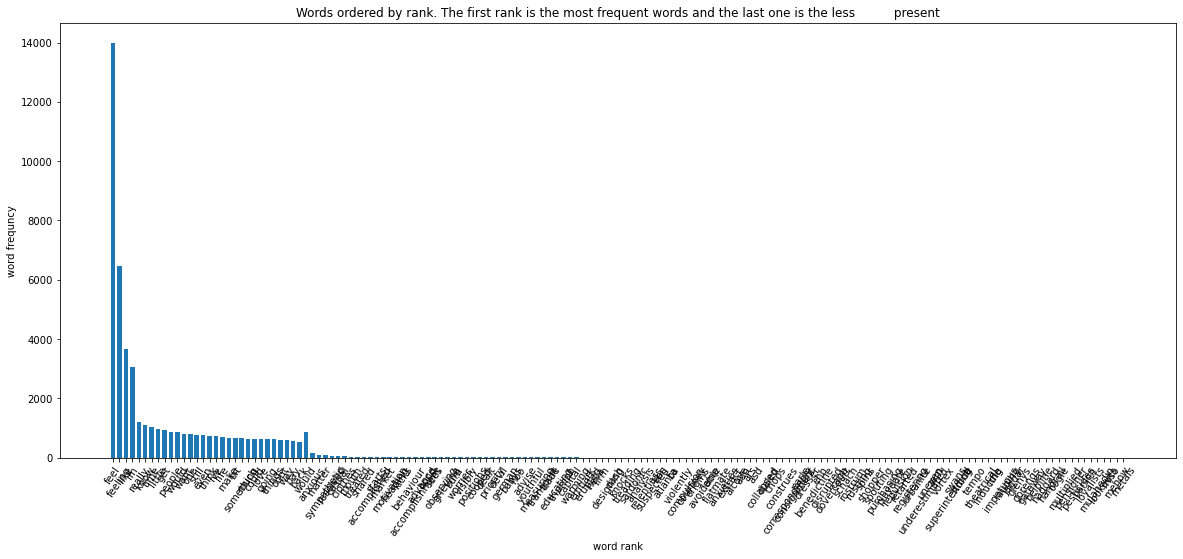

In [10]:
# Vobabulary analysis
vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(data_emo.Text)
words = vec.get_feature_names()

#words= data_emo.Text.unique()

print("vocabulary size; %d" % len(words) )


# Compute rank
wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

# Sub-sample the data to plot.
# take the 20 first + the rest sample with the given step 
def subsample(x, step=150):
    return np.hstack((x[:30], x[10::step]))


plt.figure(figsize=(20,8))
freq = subsample(wrank)
r = np.arange(len(freq))
plt.bar(r, freq, width=0.7)
plt.xticks(r, subsample(labels), rotation=55)
plt.xlabel('word rank')
plt.ylabel('word frequncy')
plt.title("Words ordered by rank. The first rank is the most frequent words and the last one is the less\
          present");


## **3) Traitement des données**  
Bien... les choses sérieuses commencent !
Dans les messages, on peut voir un certain nombre de mot non pertinant. Des numéros de téléphone "splité", des écritures différentes du même mot (and, aaand, aaaaand,....), des fautes d'orthographes,....
On pourrait se constituer un dictionnaire des "synonymes" ad hoc et voir si cela améliorerai les choses? De la même façon un nettoyage en profondeur du jeux de donnée pour retirer les "faux" mots pourrait être fait. Il faudrait prévoir un temps de Prétraitement beaucoup plus long.  

**Le "pipe" ne sera pas utilisé dans un 1er temps à cause de son temps d'exécution élevé** Les différentes classifications


### **a) Données: Phrases sans avoir retiré les stops words**

#### **a-1) Vectorisation et division des données en jeu de test et d'entrainement**  
L'affichage d'un échantillon du dictionnaire des mots utilisés permet de visualiser les problèmes non traité (mots n'ayant aucun sens, mal coupé, inutile,...).

In [11]:
vectorisation_cv = CountVectorizer()
#vectorisation_cv = CountVectorizer(ngram_range=(1, 2))
cv= vectorisation_cv.fit_transform(data_emo.Text)
feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés

#print(feature_names[:1000])

X_train, X_test, y_train, y_test = train_test_split(cv, data_emo.Emotion, test_size = 0.3,random_state=42)

#### **a-2) Test du classifier LinearSVC.**  
Les résultats sont plutôt bon sauf pour les sentiments "love" et et "surprise". Le jeux de données représentant ces 2 sentiments ne sont pas assez fourni.

In [12]:
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)
pred_LinearSVC = clf.predict(X_test)
#print('Fl Score', f1_score(y_test, y_pred, average=None))
print(classification_report(y_test,pred_LinearSVC))

"""
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.show()
"""


              precision    recall  f1-score   support

       anger       0.90      0.85      0.88       909
        fear       0.87      0.84      0.85       796
       happy       0.90      0.92      0.91      2059
        love       0.79      0.78      0.78       492
     sadness       0.91      0.93      0.92      1929
    surprise       0.77      0.74      0.76       253

    accuracy                           0.89      6438
   macro avg       0.86      0.84      0.85      6438
weighted avg       0.89      0.89      0.89      6438



"\nsns.heatmap(confusion_matrix(y_test, y_pred), annot=True)\nplt.ylabel('True classes')\nplt.xlabel('Predicted classes')\nplt.show()\n"

#### **a-3) Test du classifier LogisticRegression.**  
Les résultats sont trés proche du classifier précédent. Certains résultats sont un peu meilleurs, d'autre un peu moins bon, mais pas de manière significative.

In [13]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)
pred_logreg=logreg.predict(X_test)
print(classification_report(y_test,pred_logreg))

              precision    recall  f1-score   support

       anger       0.92      0.84      0.88       909
        fear       0.86      0.84      0.85       796
       happy       0.89      0.94      0.92      2059
        love       0.84      0.78      0.81       492
     sadness       0.91      0.94      0.92      1929
    surprise       0.80      0.68      0.74       253

    accuracy                           0.89      6438
   macro avg       0.87      0.84      0.85      6438
weighted avg       0.89      0.89      0.89      6438



### **b) Données: Phrases en ayant retiré les stops words.**  

#### **b-1) Vectorisation et division des données en jeu de test et d'entrainement**  
Le jeux de donnée contient encore beaucoup de mot non pertinent qu'il conviendrait de retirer en pré-traitement.

In [14]:
vectorisation_cv = CountVectorizer()
#vectorisation_cv = CountVectorizer(ngram_range=(1, 2))
cv= vectorisation_cv.fit_transform(data_emo.phrase_sans_stopwd)
feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés

#print(feature_names[:1000])

X_train, X_test, y_train, y_test = train_test_split(cv, data_emo.Emotion, test_size = 0.3,random_state=42)

#### **b-2) Test du classifier LinearSVC.**  
Les résultats sont plutôt bon sauf et trés proche de l'analyses sur les données brutes.

In [15]:
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)
pred_LinearSVC = clf.predict(X_test)
#print('Fl Score', f1_score(y_test, y_pred, average=None))
print(classification_report(y_test,pred_LinearSVC))

              precision    recall  f1-score   support

       anger       0.90      0.85      0.88       909
        fear       0.87      0.83      0.85       796
       happy       0.90      0.92      0.91      2059
        love       0.80      0.79      0.80       492
     sadness       0.91      0.93      0.92      1929
    surprise       0.76      0.75      0.76       253

    accuracy                           0.89      6438
   macro avg       0.86      0.85      0.85      6438
weighted avg       0.89      0.89      0.89      6438



#### **b-3) Test du classifier LogisticRegression.**  
Les résultats sont trés proche du classifier précédent.

In [16]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)
pred_logreg=logreg.predict(X_test)
print(classification_report(y_test,pred_logreg))

              precision    recall  f1-score   support

       anger       0.92      0.85      0.88       909
        fear       0.86      0.83      0.85       796
       happy       0.89      0.94      0.91      2059
        love       0.83      0.78      0.80       492
     sadness       0.91      0.94      0.92      1929
    surprise       0.79      0.71      0.75       253

    accuracy                           0.89      6438
   macro avg       0.87      0.84      0.85      6438
weighted avg       0.89      0.89      0.89      6438



### **c) Données lemanisés.**  

#### **c-1) Vectorisation et division des données en jeu de test et d'entrainement**  
Le jeux de donnée contient encore beaucoup de mot non pertinent qu'il conviendrait de retirer en pré-traitement..... Mais je pense l'avoir déjà dit :)

In [17]:
vectorisation_cv = CountVectorizer()
#vectorisation_cv = CountVectorizer(ngram_range=(1, 2))
cv= vectorisation_cv.fit_transform(data_emo.phrase_lemn_normal)
feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés

#print(feature_names[:1000])

X_train, X_test, y_train, y_test = train_test_split(cv, data_emo.Emotion, test_size = 0.3,random_state=42)

In [18]:
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)
pred_LinearSVC = clf.predict(X_test)
#print('Fl Score', f1_score(y_test, y_pred, average=None))
print(classification_report(y_test,pred_LinearSVC))

              precision    recall  f1-score   support

       anger       0.90      0.85      0.88       909
        fear       0.85      0.83      0.84       796
       happy       0.91      0.92      0.91      2059
        love       0.80      0.79      0.79       492
     sadness       0.91      0.93      0.92      1929
    surprise       0.76      0.77      0.77       253

    accuracy                           0.89      6438
   macro avg       0.86      0.85      0.85      6438
weighted avg       0.89      0.89      0.89      6438



### **d) Conclusion.**  
Sur ce jeux de données, les différents classifiers ainsi que les différentes sources de données (avec ou sans stop words, lémanisé ou pas) n'apporte pas de différences majeures. La liste de mots devraient être mieux retravaillée avec l'utilisation de regex. C'est particulièrement vrai pour le 2ème jeux de donnée beaucoup plus complexe et avec des résultats qui sont eux trés décevant (contrairement à ce jeux de données!).

## **II) On travail sur le fichier text_emotion.csv**

In [19]:
# Lecture du fichiern et création de la data frame.
#  Nom des colonnes: tweet_id, sentiment, author, content
#  Liste des sentiments : 'empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
#    'hate' 'happiness' 'boredom' 'relief' 'anger'

data_emo2= pds.read_csv('./visu/data/text_emotion.csv')
#, engine= "python", encoding='utf-8', error_bad_lines=False) # POUR GOOGLE COLAB SINON ERREUR!

print("Nombre de message:",len(data_emo2))

df_count_emotion = data_emo2.groupby(['sentiment']).size().reset_index(name='compt')
print("Les émotions....:\n",df_count_emotion)

df_count_author = data_emo2.groupby(['author']).size().reset_index(name='compt')
#print(df_count_author)
print("Les auteurs par ordres décroissant du nombre de message postés:\n",
      df_count_author.sort_values(by= "compt", ascending = False).head(30))


Nombre de message: 40000
Les émotions....:
      sentiment  compt
0        anger    110
1      boredom    179
2        empty    827
3   enthusiasm    759
4          fun   1776
5    happiness   5209
6         hate   1323
7         love   3842
8      neutral   8638
9       relief   1526
10     sadness   5165
11    surprise   2187
12       worry   8459
Les auteurs par ordres décroissant du nombre de message postés:
                 author  compt
7942       MissxMarisa     23
2171      ChineseLearn     22
7668    MiDesfileNegro     19
18330       erkagarcia     19
24210         lost_dog     18
32187         tsarnick     17
6093        KimmiMcfly     15
23944      linnetwoods     15
3079           Dogbook     14
15739      cece_newnew     14
26091  mrs_mcsupergirl     14
32248       twebbstack     14
9312             Quimo     14
21495  jesssicababesss     13
17396    divxdownloads     13
24184     lopezwilfred     12
11650     TraceyHewins     12
23713        lesley007     12
11577        

## **1) Récupération des données**  
Ce fichier contient 4 colonnes: **tweet_id**, **sentiment**, **author**, **content**. Les émotions associées aux messages (colonne content) sont:  
**anger** (110 messages), **boredom** (179 messages), **empty** (827 messages), **enthusiasm** (759 messages), **fun** (1776  messages), **happiness** (5209 messages), **hate** (1323 messages), **love** (3842 messages), **neutral** (8638 messages), **relief** (1526 messages), **sadness** (5165 messages), **surprise** (2187  messages) et **worry** (8459  messages).  
Nombre de messages: 40 000  
  
En ce qui concerne le texte brut, on voit qu'il sera nécessaire de faire un pré-traitement à l'aide de regex (que je n'ai pu faire, faute de temps). Les @toto indiquants la personne à qui s'adresse le message, les abréviations, les différentes écriture du même mots, les émoticones (complexes car nombreux et avec de nombreuse "orthographe" possible devront impérativement être traité pour espérer aboutir a des résultats correctes.  
  
Les n-grams devront être rechercher et leur pertinance analysée (exemple: lady gaga).  
  
La sous représentation de certains sentiments ne permettentront pas une grande précision (même problème que sur le 1er jeux de donnée).  
  
Il faudrai aussi renomer quelques sentiments pour avoir la même étiquette (happy et happyness).

In [20]:
data_emo2.content.head(20)

0     @tiffanylue i know  i was listenin to bad habi...
1     Layin n bed with a headache  ughhhh...waitin o...
2                   Funeral ceremony...gloomy friday...
3                  wants to hang out with friends SOON!
4     @dannycastillo We want to trade with someone w...
5     Re-pinging @ghostridah14: why didn't you go to...
6     I should be sleep, but im not! thinking about ...
7                  Hmmm. http://www.djhero.com/ is down
8               @charviray Charlene my love. I miss you
9            @kelcouch I'm sorry  at least it's Friday?
10                                     cant fall asleep
11                              Choked on her retainers
12    Ugh! I have to beat this stupid song to get to...
13    @BrodyJenner if u watch the hills in london u ...
14                                         Got the news
15        The storm is here and the electricity is gone
16                                 @annarosekerr agreed
17    So sleepy again and it's not even that lat

## **2) Pré-traitement des données**

### **a) Tokenisation**  
Bien que cette opération soit incluse dans la vectorisation et est donc inutile à ce stade, elle est réalisée à titre d'exercice. Elle pourrait aussi servir pour faciliter un pré traitement des donnéees (pour repérer plus facilement les émoticones par exemple et les ré-associé comme 1 seul mots. les émoticones suivant :), :-), =], :D serait remplacé par le mot sourire ou laissé tel quel).  
  
On crée aussi une nouvelle colonne que l'on rajoute à la data frame de départ contenant le texte "tokénisé".

In [21]:
# Tokenisation

# Création d'une colonne tokenisée
corpus=[]
for el in data_emo2.content:
    token= word_tokenize(el)
    corpus.append(token)
data_emo2['token_brut'] = pds.Series(corpus)
#print(data_emo2.token_brut.head(10))

In [22]:
# Création d'une colonne tokenisée sans stopwords avec ponctuation (important pour les émoticones)
stopwords=nltk.corpus.stopwords.words('english')
#stopwords.extend(exclude)

corpus=[]
for el in data_emo2.token_brut:
    token=[]
    for wd in el:
        if wd not in stopwords:
            token.append(wd)
    corpus.append(token)
data_emo2['token_sans_stopwd'] = pds.Series(corpus)

#data_emo2.token_sans_stopwd.head(10)

In [23]:
# À partir de la cellule précédente on ré-écrit les phrase sans stopword (utilisé par la suite 
#  avec la vectorisation)

corpus= data_emo2['token_sans_stopwd']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el) # Magique! 
    corpus2.append(ligne)

data_emo2['phrase_sans_stopwd'] = pds.Series(corpus2)

#print(data_emo2.phrase_sans_stopwd.head(20))

In [24]:
# Lemantisation et normalisation

lemma = WordNetLemmatizer()

corpus=[]
#print(stopwords)
for el in data_emo2.token_sans_stopwd:
    token=[]
    token=[lemma.lemmatize(word.lower()) for word in el]
    corpus.append(token)

data_emo2['lemn_normal'] = pds.Series(corpus)

#data_emo2.lemn_normal.head(10)

In [25]:
# Création d'une colonne de phrase Lemantisé.

corpus= data_emo2['lemn_normal']

corpus2=[]
for el in corpus:
    ligne=''
    ligne = ' '.join(el)
    corpus2.append(ligne)

data_emo2['phrase_lemn_normal'] = pds.Series(corpus2)

#print(data_emo2.phrase_lemn_normal.head(20))

## **3) Traitement des données**  
Bien... les choses sérieuses commencent !
Dans les messages, on peut voir un certain nombre de mot non pertinant. Des numéros de téléphone "splité", des écritures différentes du même mot (and, aaand, aaaaand,....), des fautes d'orthographes,....
On pourrait se constituer un dictionnaire des "synonymes" ad hoc et voir si cela améliorerai les choses? De la même façon un nettoyage en profondeur du jeux de donnée pour retirer les "faux" mots pourrait être fait. Il faudrait prévoir un temps de Prétraitement beaucoup plus long.  

**Le "pipe" ne sera pas utilisé dans un 1er temps à cause de son temps d'exécution élevé** Les différentes classifications


### **a) Données: Phrases aprés avoir retiré les stops words et en utilisants les unigram et bigram**  
Les 1er test n'ayant pas été concluant on tente une amélioration par utilisation des n-gram.... Mais cela restera trés décevant.

In [26]:
vectorisation_cv = CountVectorizer(ngram_range=(1, 2))
cv= vectorisation_cv.fit_transform(data_emo2.phrase_sans_stopwd)
feature_names = vectorisation_cv.get_feature_names() # dictionnaire des mots utilisés
#print(feature_names[:1000])

X_train, X_test, y_train, y_test = train_test_split(cv, data_emo2.sentiment, test_size = 0.3,random_state=42)

#### **a-2) Test du classifier LinearSVC.**  
Les résultats sont plutôt bon sauf pour les sentiments "love" et et "surprise". Le jeux de données représentant ces 2 sentiments ne sont pas assez fourni.

In [27]:
clf = LinearSVC(max_iter=1000)
clf.fit(X_train, y_train)
pred_LinearSVC = clf.predict(X_test)
#print('Fl Score', f1_score(y_test, y_pred, average=None))
print(classification_report(y_test,pred_LinearSVC))

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        33
     boredom       0.06      0.02      0.03        57
       empty       0.02      0.00      0.01       242
  enthusiasm       0.02      0.00      0.01       249
         fun       0.12      0.04      0.06       513
   happiness       0.33      0.32      0.32      1568
        hate       0.27      0.19      0.22       383
        love       0.41      0.40      0.40      1134
     neutral       0.35      0.55      0.43      2620
      relief       0.14      0.06      0.08       515
     sadness       0.30      0.27      0.28      1560
    surprise       0.12      0.05      0.07       625
       worry       0.33      0.37      0.35      2501

    accuracy                           0.32     12000
   macro avg       0.19      0.17      0.17     12000
weighted avg       0.29      0.32      0.30     12000



#### **a-3) Test du classifier LogisticRegression.**  
Les résultats sont trés proche du classifier précédent.

In [28]:
logreg= LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)
pred_logreg=logreg.predict(X_test)
print(classification_report(y_test,pred_logreg))

KeyboardInterrupt: 

### **b) Conclusion.**  
Reprendre le pré-traitement, inutile à ce stade de continuer les tests de classification!

## **III) Implémentation du pipeline**

In [32]:
from time import time
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation

corpus= data_emo.Text
targets= data_emo.Emotion

import numpy as np


pipe0 = Pipeline([
    ('vect', CountVectorizer()),
    ('sgd', SGDClassifier()),
])
pipe1 = Pipeline([
    ('vect', CountVectorizer()),
    ('svm', SVC()),
])
pipe2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
])
pipe3 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svml', LinearSVC()),
])
pipe4 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC()),
])
pipe5 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logit', LogisticRegression()),
])
pipe6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mult_nb', MultinomialNB()),
])
pipe7 = Pipeline([
    ('vect', CountVectorizer()),
    ('compl_nb', ComplementNB()),
])
pipe8 = Pipeline([
    ('vect', CountVectorizer()),
    ('bern_nb', BernoulliNB()),
])

def run_pipes(pipes, splits=10, test_size=0.2, seed=42):  
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed)
    for idx_train, idx_test in spliter.split(corpus):
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])
            
            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]
            
            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start
            
            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                precision_score(y_test, y, average=None),
                pipe.score(X_test, y_test),
                f1_score(y_test, y, pos_label=0, average=None),
                recall_score(y_test, y, pos_label=0, average=None),
            ])
    return res

def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model],dtype='object')
        final[model] = {
            "time" : round(arr[:, 0].mean(),3),
            "precision":arr[:, 1].mean(),
            "score":arr[:, 2].mean(),
            "f1_score": [arr[:,3].mean(), arr[:,3].std()],
            "recall": arr[:,4].mean(),
            #"f1": arr[:,4].mean(),
        }

    df = pds.DataFrame.from_dict(final, orient="index")
    return df

"""
def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0].mean().round(2),
            "f1_spam": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_ham": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
        }

    df = pds.DataFrame.from_dict(final, orient="index").round(3)
    return df
"""

'\ndef print_table(res):\n    # Compute mean and std\n    final = {}\n    for model in res:\n        arr = np.array(res[model])\n        final[model] = {\n            "time" : arr[:, 0].mean().round(2),\n            "f1_spam": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],\n            "f1_ham": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],\n        }\n\n    df = pds.DataFrame.from_dict(final, orient="index").round(3)\n    return df\n'

In [37]:
# run base pipes
res01 = run_pipes([pipe0,pipe1], splits=1)

In [38]:
res23 = run_pipes([pipe2,pipe3], splits=1)

In [39]:
res45 = run_pipes([pipe4,pipe5], splits=1)

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1267: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [46]:
res67 = run_pipes([pipe6,pipe7], splits=1)

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1267: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1267: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [43]:
res8 = run_pipes([pipe8], splits=1)

/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpphi/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1267: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn("Note that pos_label (set to %r) is ignored when "


In [40]:
print_table(res01)

,time,precision,score,f1_score,recall
vect-sgd,0.858,"[0.9168141592920354, 0.842391304347826, 0.9049...",0.889329,"[[0.8764805414551607, 0.8587257617728531, 0.91...","[0.839546191247974, 0.8757062146892656, 0.9239..."
vect-svm,131.900,"[0.9376498800959233, 0.8173076923076923, 0.725...",0.789376,"[[0.7562862669245648, 0.7180570221752904, 0.82...","[0.6337115072933549, 0.64030131826742, 0.95727..."


In [41]:
print_table(res23)

,time,precision,score,f1_score,recall
vect-tfidf-sgd,0.675,"[0.9312169312169312, 0.8800773694390716, 0.881...",0.895154,"[[0.891891891891892, 0.8683206106870228, 0.915...","[0.8557536466774717, 0.8568738229755178, 0.952..."
vect-tfidf-svml,0.953,"[0.9183673469387755, 0.8888888888888888, 0.903...",0.901678,"[[0.8962655601659751, 0.8735632183908045, 0.92...","[0.8752025931928687, 0.8587570621468926, 0.940..."


In [42]:
print_table(res45)

,time,precision,score,f1_score,recall
vect-tfidf-svm,133.098,"[0.9306930693069307, 0.8516949152542372, 0.806...",0.852516,"[[0.8377896613190731, 0.8015952143569292, 0.87...","[0.7617504051863857, 0.7570621468926554, 0.957..."
vect-tfidf-logit,3.592,"[0.925, 0.8662420382165605, 0.8218497827436375...",0.861370,"[[0.8460861917326298, 0.81437125748503, 0.8850...","[0.779578606158833, 0.768361581920904, 0.95872..."


In [47]:
print_table(res67)

,time,precision,score,f1_score,recall
vect-mult_nb,0.443,"[0.9012658227848102, 0.8277945619335347, 0.717...",0.751631,"[[0.7035573122529645, 0.6357308584686774, 0.81...","[0.5769854132901134, 0.5160075329566854, 0.953..."
vect-compl_nb,0.434,"[0.8986486486486487, 0.8465909090909091, 0.882...",0.880009,"[[0.880066170388751, 0.8441926345609065, 0.898...","[0.8622366288492707, 0.8418079096045198, 0.915..."


In [45]:
print_table(res8)

,time,precision,score,f1_score,recall
vect-bern_nb,0.445,"[0.865, 0.795774647887324, 0.6790314270994333,...",0.655405,"[[0.423500611995104, 0.33580980683506684, 0.79...","[0.28038897893030795, 0.2128060263653484, 0.95..."
